# Time Travel Task Analyses

This notebook contains the analyses necessary to generate the results for the Time Travel Task. The time travel task outputs a binary format log file for space efficiency which first needs to be converted to the appropriate intermediate representations (the iPosition format for test results and an intermediate navigation format for study/test navigation results).

<div class="alert alert-block alert-info">Note: Many of these processing steps can take quite a long time to run as they're processing several gigabytes of data. This issue is compounded if the data is being held on a server. If the intermediate data files have already been generated, it is advisable to skip the steps which regenerate them. These slow code blocks are marked with a note box.</div>

## Data Directories

In order to run most cells in this notebook, these data directories need to be defined (and filled with the appropriate data - see the [Data Conversion](#Data-Conversion) section below to generate the data_output_directory contents).

In [1]:
data_directory = r'C:\Users\Kevin\Documents\GitHub\msl-iposition-pipeline\examples\saved_data\Paper Data (cleaned)'
data_output_directory = r'C:\Users\Kevin\Documents\GitHub\msl-iposition-pipeline\examples\saved_data\Paper Data (iPosition Format)'

generate_intermediate_files = False  # If true, the cells which generate intermediate files will run (they are very slow)

## Data Conversion

First we'll process the data into the appropriate formats.

In [2]:
import cogrecon.core.data_flexing.time_travel_task.time_travel_task_to_iposition as ttt2i

<div class="alert alert-block alert-info">Note: The next cell can take a significant amount of time to run and should only be run on an **empty** directory (otherwise it will append to the files in the directory).

<br><br>To run the cell, set generate_intermediate_files to True (in [Data Directories](#Data-Directories)).
</div>

In [3]:
if 'generate_intermediate_files' in vars() and generate_intermediate_files:
    ttt2i.time_travel_task_to_iposition(data_directory, data_output_directory)

## Test Intermediate Data

For test, there are several primary analyses to be run. First, a basic analysis for the purpose of determining the test-time performance in space or in time are performed. This can be done quite simply with the basic batch processing functions.

Note that these files contain all the output metrics necessary to perform the statistics on Space/Time Misplacement, Number of Incorrect Event Types, Miassignments in Space vs. Time, and Context Boundary Effects.

In [4]:
from cogrecon.core.batch_pipeline import batch_pipeline
from cogrecon.core.data_flexing.time_travel_task.time_travel_task_analytics import summarize_test_data

<div class="alert alert-block alert-info">Note: The next cell can take a significant amount of time to run. If the intermediate data file (*time_travel_task_test_summary.csv* by default) already exists, consider skipping the next cell.<br><br>To run the cell, set generate_intermediate_files to True (in [Data Directories](#Data-Directories)).</div>

In [5]:
if 'generate_intermediate_files' in vars() and generate_intermediate_files:
    summarize_test_data(search_directory=data_directory)  # For Time Travel Task specific analyses

## Test Data Analyses

This subsection contains the analyses which generate basic statistics of interest for the following values:

 * Misplacement in Space
 * Misplacement in Time
 * Number of Events Incorrect
 * Misassignments in Space
 * Misassignments in Time
 * Context-Boundary Effects (in Time)

<div class="alert alert-block alert-info">Note that this section requires the intermediate files (generated above) to execute.</div>

In [6]:
# For Time vs. Space Reconstruction Analyses
if 'generate_intermediate_files' in vars() and generate_intermediate_files:
    batch_pipeline(str(data_output_directory), 'TimeTravelTask_SpaceOnly.csv', data_shape=(4, 10, 3),
                   collapse_trials=False, trial_by_trial_accuracy=False,
                   dimension=3, removal_dim_indicies=[2], actual_coordinate_prefixes=True)
    batch_pipeline(str(data_output_directory), 'TimeTravelTask_TimeOnly.csv', data_shape=(4, 10, 3),
                   collapse_trials=False, trial_by_trial_accuracy=False,
                   dimension=3, removal_dim_indicies=[0, 1], actual_coordinate_prefixes=True)
    batch_pipeline(str(data_output_directory), 'TimeTravelTask_CombinedSpaceAndTime.csv', data_shape=(4, 10, 3),
                   collapse_trials=False, trial_by_trial_accuracy=False,
                   dimension=3, actual_coordinate_prefixes=True)

### Intermediate Files

In [7]:
test_summary_filename = 'time_travel_task_test_summary.csv'
test_cogrecon_space_only_filename = 'TimeTravelTask_SpaceOnly.csv'
test_cogrecon_time_only_filename = 'TimeTravelTask_TimeOnly.csv'

### Visualization Helper Function

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_columns(data, column_names, titles, ylabels, fig_size=(15, 5), separate_plots=True, legend_labels=None, subplot_shape=None):
    # Extract the columns of interest
    trial_num = data['trial']
    columns = [data[c_name] for c_name in column_names]
    
    # Generate useful constants
    trials = list(set(trial_num))
    num_items = 10
    num_participants = len(trial_num)
    means = [[np.mean(column[trial_num == i]) for i in trials] for column in columns]
    std_errs = [[np.std(column[trial_num == i])/np.sqrt(num_participants) for i in trials] for column in columns]
    
    # Visualize each trial-over-trial mean in a subplot
    if separate_plots:
        if subplot_shape is None:
            f, axarr = plt.subplots(1, len(column_names))
        else:
            f, axarr = plt.subplots(*subplot_shape)
            axarr = [j for i in axarr for j in i]
        if len(column_names) == 1:
            axarr = [axarr]
        f.set_size_inches(fig_size)
        for ax, title, mean, std_err, ylabel in zip(axarr, titles, means, std_errs, ylabels):
            ax.errorbar(trials, mean, std_err)
            ax.set_title(title)
            ax.grid(True)
            ax.set_xlabel('Trials')
            ax.set_ylabel(ylabel)
            ax.xaxis.set_ticks(trials)
        plt.show()
    else:
        f = plt.figure()
        f.set_size_inches(fig_size)
        for idx, (title, mean, std_err, ylabel) in enumerate(zip(titles, means, std_errs, ylabels)):
            label = ''
            if legend_labels is not None:
                label = legend_labels[idx]
            plt.errorbar(trials, mean, std_err, label=label)
            plt.title(title)
            plt.grid(True)
            plt.xlabel('Trials')
            plt.ylabel(ylabel)
            plt.gca().xaxis.set_ticks(trials)
            plt.legend()
        plt.show()

### Misplacement (in Space and Time) and Events

In [9]:
import pandas

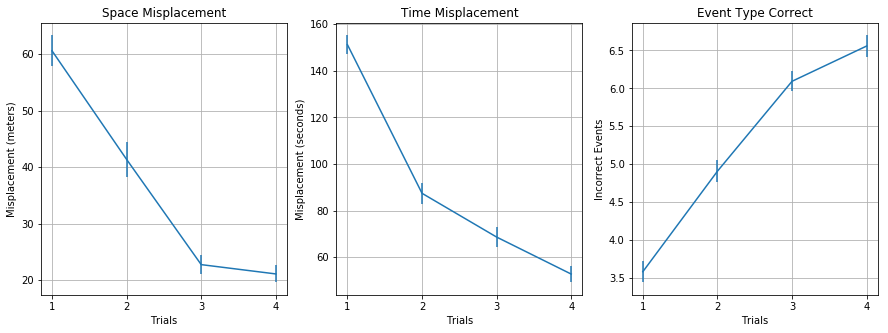

In [10]:
# Load the data
data = pandas.read_csv(test_summary_filename)

columns =  ['space_misplacement', 'time_misplacement', 'event_type_correct_count']
titles = ['Space Misplacement', 'Time Misplacement', 'Event Type Correct']
ylabels = ['Misplacement (meters)', 'Misplacement (seconds)', 'Incorrect Events']
visualize_columns(data, columns, titles, ylabels)

### Misassignments (in Space and Time)

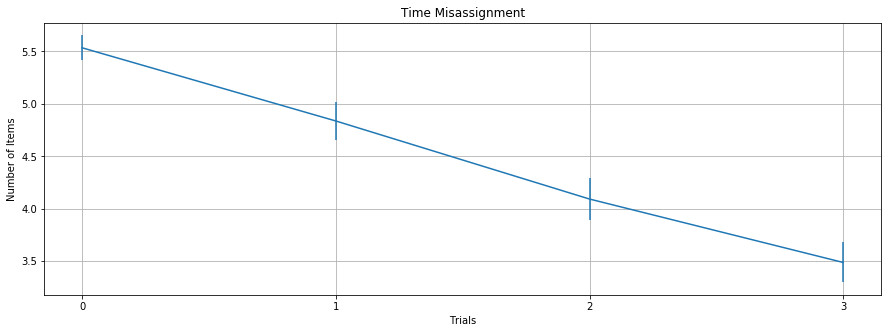

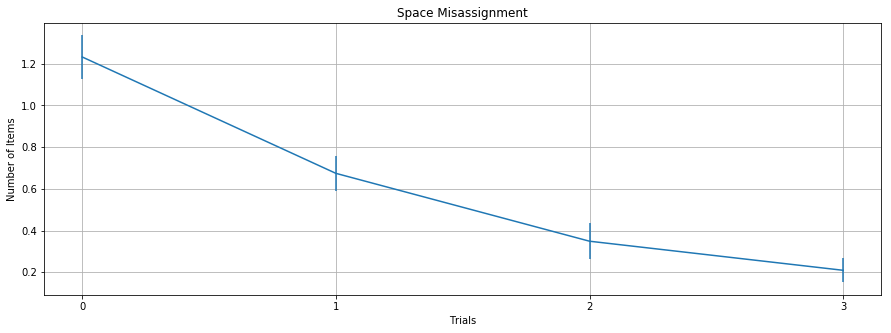

In [11]:
# Load the data
data_time = pandas.read_csv(test_cogrecon_time_only_filename, skiprows=1)
data_space = pandas.read_csv(test_cogrecon_space_only_filename, skiprows=1)

visualize_columns(data_time, ['Accurate Misassignment'], ['Time Misassignment'], ['Number of Items'])
visualize_columns(data_space, ['Accurate Misassignment'], ['Space Misassignment'], ['Number of Items'])

### Context Boundary Effects (in Time)

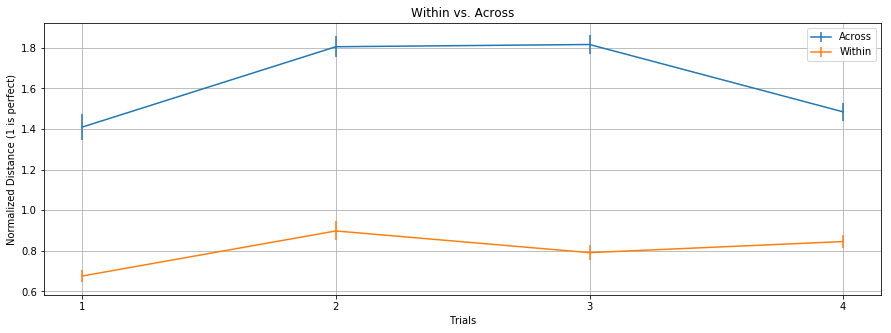

In [12]:
# Load the data
data_time = pandas.read_csv(test_summary_filename)

columns = ['context_crossing_dist_exclude_wrong_color_pairs', 'context_noncrossing_dist_exclude_wrong_color_pairs']
titles = ['', 'Within vs. Across']
legend_labels = ['Across', 'Within']
ylabels = ['Normalized Distance (1 is perfect)', 'Normalized Distance (1 is perfect)']

visualize_columns(data_time, columns, titles, ylabels, separate_plots=False, legend_labels=legend_labels)

## Effect of Context on Misassignment

The analysis of the effect of context on misassignment is not included in any of the packages directly. As a result, we need to do some custom computation to get out these numbers.

First, we need to read the data from the **Accurate Misassignment Pairs** column in the temporal only test output file. Because we're running this in one file, we can simply extract this from the output result rather than reading from file.

In [13]:
import ast
import pandas
import numpy as np
from cogrecon.core.batch_pipeline import get_header_labels

In [14]:
# Load the data
data = pandas.read_csv('TimeTravelTask_TimeOnly.csv', skiprows=1)
misassignment_pairs = [ast.literal_eval(row) for row in data['Accurate Misassignment Pairs']]

Next we'll process the list, counting the number of within vs. across context pairs.

In [15]:
# The pairs which share a context (note that order doesn't matter for this)
within_key = [[0, 1], [1, 0], [2, 3], [3, 2], [4, 5], [5, 4], [6, 7], [7, 6]]
# The items to exclude because they had no contextual information
# thus if they were given temporal information, they would not be a valid misassignment
exclusion_items = [8, 9]

within_list = []
across_list = []
totals_list = []
for i, a in enumerate(misassignment_pairs):
    totals_list.append(len(a))
    within_list.append(0)
    across_list.append(0)
    for el in a:
        if all([el_i not in exclusion_items for el_i in el]):
            if el in within_key:
                within_list[-1] += 1
            else:
                across_list[-1] += 1
within_list_proportion = [float(x)/float(y) if y is not 0 else np.nan for x, y in zip(within_list, totals_list)]
across_list_proportion = [float(x)/float(y) if y is not 0 else np.nan for x, y in zip(across_list, totals_list)]

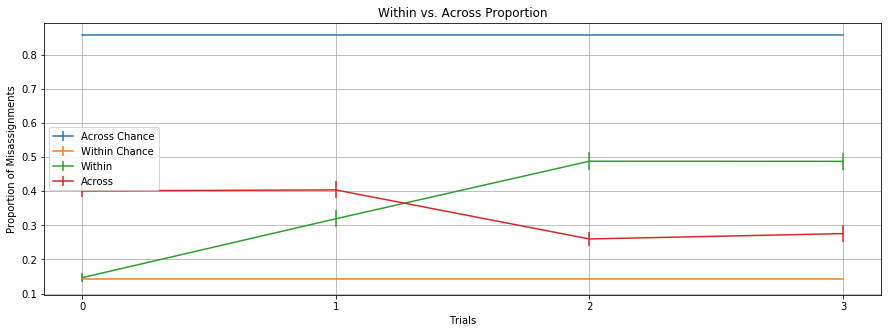

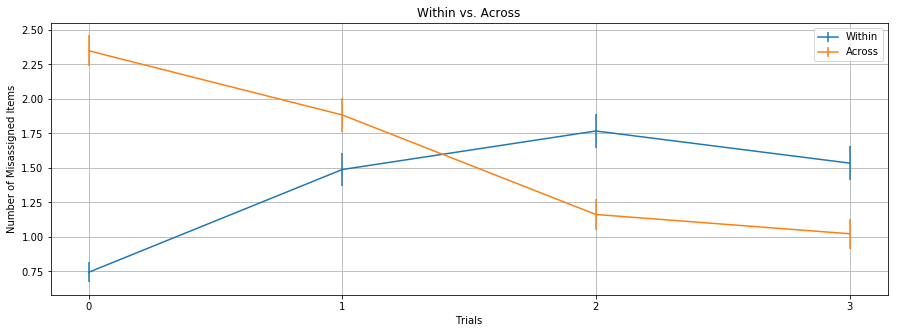

In [16]:
data = pandas.read_csv('TimeTravelTask_TimeOnly.csv', skiprows=1)

num_elements = len(within_list_proportion)

data['within_list_proportion'] = pandas.Series(within_list_proportion)
data['across_list_proportion'] = pandas.Series(across_list_proportion)
data['within'] = pandas.Series(within_list)
data['across'] = pandas.Series(across_list)
data['top'] = pandas.Series([6./7.]*num_elements)
data['bottom'] = pandas.Series([1./7.]*num_elements)

columns_proportion = ['top', 'bottom', 'within_list_proportion', 'across_list_proportion']
titles_proportion = ['', '', '', 'Within vs. Across Proportion']
legend_labels_proportion = ["Across Chance", "Within Chance", "Within", "Across"]
ylabels_proportion = ['', '', '', 'Proportion of Misassignments']

columns = ['within', 'across']
titles = ['', 'Within vs. Across']
legend_labels = ["Within", "Across"]
ylabels = ['', 'Number of Misassigned Items']

visualize_columns(data, columns_proportion, titles_proportion, ylabels_proportion, separate_plots=False, legend_labels=legend_labels_proportion)
visualize_columns(data, columns, titles, ylabels, separate_plots=False, legend_labels=legend_labels)

Next we can save these results to an intermediate file for running statistics.

In [17]:
if 'generate_intermediate_files' in vars() and generate_intermediate_files:
    with open('misassignments_by_context.csv', 'w') as fp:
        fp.write('subID,trial,total_misassignments,within_misassignments,across_misassignments,within_misassignment_proportions,across_misassignment_proportions\n')
        for sid, tr, t, w, a, wp, ap in zip(data['subID'], data['trial'], totals_list,within_list ,across_list,within_list_proportion,across_list_proportion):
            fp.write('{0},{1},{2},{3},{4},{5},{6}\n'.format(sid, tr, t, w, a, wp, ap))

## Navigation Intermediate Data

Next, we can create the summary file for navigation metrics.

In [2]:
from cogrecon.core.data_flexing.time_travel_task.time_travel_task_analytics import summarize_navigation_data

<div class="alert alert-block alert-info">Note: The next cell can take a significant amount of time to run. If the intermediate data file (*time_travel_task_navigation_summary.csv* by default) already exists, consider skipping the next cell.<br><br>To run the cell, set generate_intermediate_files to True (in [Data Directories](#Data-Directories)).</div>

In [ ]:
if 'generate_intermediate_files' in vars() and generate_intermediate_files:
    summarize_navigation_data(search_directory=data_directory)  # For Time Travel Task specific analyses

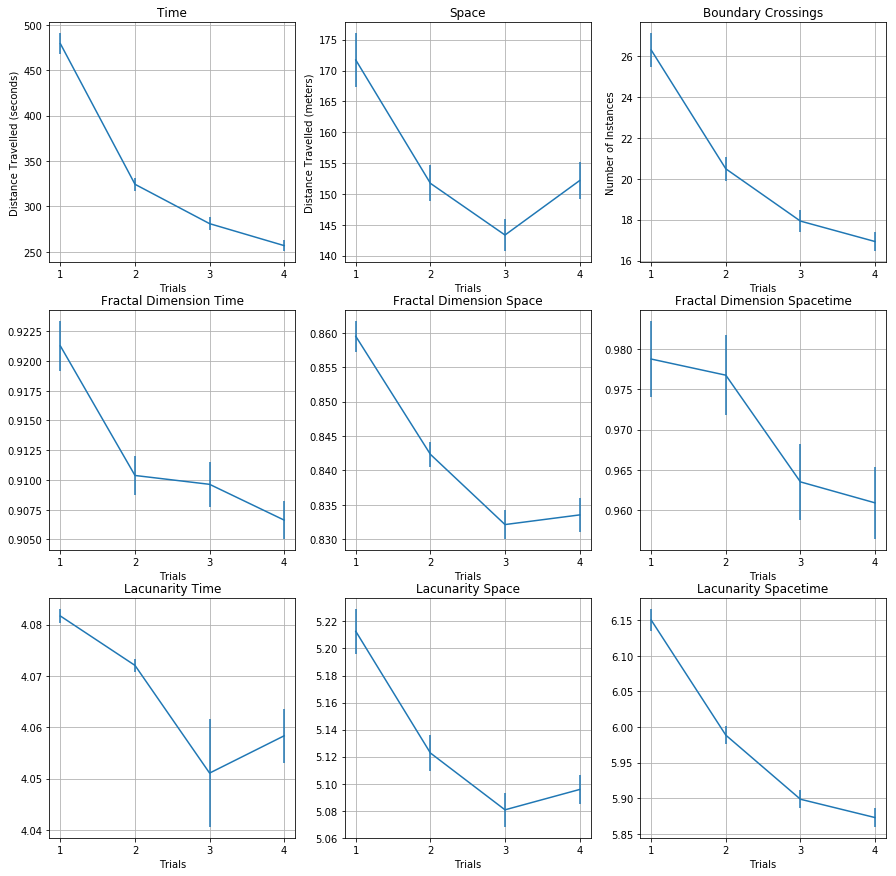

In [18]:
import pandas

# Load the data
data_nav = pandas.read_csv('time_travel_task_navigation_summary.csv')

columns = ['time_travelled', 'space_travelled', 'context_boundary_crossings',
           'fd_time', 'fd_space', 'fd_spacetime',
           'lacunarity_time', 'lacunarity_space', 'lacunarity_spacetime']
titles = ['Time', 'Space', 'Boundary Crossings',
          'Fractal Dimension Time', 'Fractal Dimension Space', 'Fractal Dimension Spacetime',
          'Lacunarity Time', 'Lacunarity Space', 'Lacunarity Spacetime']
ylabels = ['Distance Travelled (seconds)', 'Distance Travelled (meters)', 'Number of Instances',
           '', '', '', '', '', '']

visualize_columns(data_nav, columns, titles, ylabels, separate_plots=True, subplot_shape=[3, 3], fig_size=(15, 15))

## Linear Mixed Effect Modeling of Navigation vs. Test Variables

In progress...

In [ ]:
import rpy2
import pandas
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
# Load all data
data_summary = pandas.read_csv(test_summary_filename)
data_time = pandas.read_csv(test_cogrecon_time_only_filename, skiprows=1)
data_space = pandas.read_csv(test_cogrecon_space_only_filename, skiprows=1)
data_nav = pandas.read_csv('time_travel_task_navigation_summary.csv')
data_missassignment_by_context = pandas.read_csv('misassignments_by_context.csv')

# Fix inconsistent indexing in some files
data_space['trial'] = [x+1 for x in data_space['trial'].values]
data_time['trial'] = [x+1 for x in data_time['trial'].values]
data_missassignment_by_context['trial'] = [x+1 for x in data_missassignment_by_context['trial'].values]

# Confirm subID and trial match across all data
assert all([a==b==c==d for a,b,c,d in zip(data_nav['subID'].values, data_time['subID'].values, data_space['subID'].values, data_summary['subID'].values)]), 'subIDs do not match in intermediate files'
assert all([a==b==c==d for a,b,c,d in zip(data_nav['trial'].values, data_time['trial'].values, data_space['trial'].values, data_summary['trial'].values)]), 'trials do not match in intermediate files'

data = pandas.DataFrame()
data['subID'] = data_summary['subID']
data['trial'] = data_summary['trial']

data['space_travelled'] = data_nav['space_travelled']
data['time_travelled'] = data_nav['time_travelled']

data['space_misplacement'] = data_summary['space_misplacement']
data['time_misplacement'] = data_summary['time_misplacement']
data['event_type_correct_count'] = data_summary['event_type_correct_count']
# data['cbe'] = data_summary['context_crossing_dist_exclude_wrong_color_pairs'] - data_summary['context_noncrossing_dist_exclude_wrong_color_pairs']
data['accurate_misassignment_space'] = data_space['Accurate Misassignment']
data['accurate_misassignment_time'] = data_time['Accurate Misassignment']
data['within_misassignments'] = data_missassignment_by_context['within_misassignments']
data['across_misassignments'] = data_missassignment_by_context['across_misassignments']

In [ ]:
X = data[['space_misplacement', 'time_misplacement', 'event_type_correct_count', # 'cbe', 
          'accurate_misassignment_space', 'accurate_misassignment_time', 
          'within_misassignments', 'across_misassignments']]
y = data[['space_travelled', 'time_travelled']]

cov = data['trial']